# Install libraries # !pip install -r requirements.txt

In [1]:
#!pip install -r requirements.txt

In [1]:
# These magics allow changes to Python files to automatically reloaded
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

import logging
import wandb

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)

from pathlib import Path
import os
from multiprocessing import cpu_count
from uuid import uuid1
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
#from torchscan import summary
import torchvision

from pytorch_lightning import Trainer, seed_everything

from libraries.lightningDM import ImageFolderLightningDataModule, WhoiDataModule, ZooscanDataModule, LenslessDataModule, ZooLakeDataModule
from libraries.lightningModel import SeggregatedBACNN
from libraries.helper_functions import class_histogram, sample_images

/home/jhimbert/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jhimbert/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jhimbert/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jhimbert/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jhimbert/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89:

#### Enter the number of the desired dataset in the [] - e.g. plankton_dataset['1']. Also enter the model name,desired image size, batch size and seed value

In [2]:
plankton_dataset = {
        '1': ['WHOI',       WhoiDataModule,     "whoi_dictionary.pkl"],           
        '2': ['Zooscan',    ZooscanDataModule,  "zs_dictionary.pkl"],  # 93 taxa classes and 1,433,278 images taken from EcoTaxa
        '3': ['Lensless',   LenslessDataModule, "ll_dictionary.pkl"],
        '4': ['Zoolake',    ZooLakeDataModule,  "zl_dictionary.pkl"], 
    }

""" Change the number in the brackets for the dataset you want to use """
dataset = plankton_dataset['2']



In [4]:
model_name = 'test_hierar'


learning_rate = 0.001
learning_rate_finder = True

img_size = 224
batch_size = 16
sampler = True # set True to use Weighted Random Sampler, otherwise false

attention_size = 768//2
feature_extractor_path= 'swin_ZS_v3_backbone.ckpt'
freeze_feature_extractor=True
freeze_binary_head=False
training_only_binary_head=False

# Scheduler
scheduler = 'reduce_lr_on_plateau' #'reduce_lr_on_plateau' #'exponential_lr'
scheduler_parameters = {
        ## For cosine_annealing
            'T_max': 10,
            'eta_min': 0,
    
        ## For reduce on plateau
            'patience': 1,
            'min_lr': 0,
    
        ## For exponenetial decay
            'gamma': 1.1
        }

loss_weights0 = [0.98, 0.01, 0.01]
loss_weights1 = [0.1, 0.8, 0.1]
loss_weights2 = [0.1, 0.2, 0.7]
loss_weights3 = [0.01, 0.01, 0.99]

num_epochs0 = 15
num_epochs1 = 25
num_epochs2 = 35
num_epochs3 = 50

# Variables for Random Augmentations
manual_augmentations = True # False
number_of_augmentations = 4
magnitude_of_augmentations = 8

seed_value = 42

seed_everything(seed_value)
dataset_name = dataset[0]
image_folder = dataset_name + '_hierarchical_imagefolder'

INFO:Global seed set to 42


#### Create a directory to store all experiments in

In [5]:
# Define the base directory name
base_dir_name = f"{model_name}_{dataset_name}"

# Initialize Experiment_num to 1
Experiment_num = 4

EXPERIMENTS = Path.cwd() / "experiments_folder"
EXPERIMENTS.mkdir(exist_ok=True)

# Check if experiment folder already exists
while True:
    EXPERIMENT_FOLDER = EXPERIMENTS / f"{base_dir_name}_v{Experiment_num}"
    if EXPERIMENT_FOLDER.exists():
        # If the experiment folder exists, prompt the user to update the experiment number or exit
        print("Experiment folder already exists!")
        user_input = input("Do you want to update the experiment number? (Y/N): ")
        if user_input.upper() == "Y":
            Experiment_num += 1
        else:
            break
    else:
        # If the experiment folder does not exist, create the folder and exit the loop
        EXPERIMENT_FOLDER.mkdir(exist_ok=True)
        print("Experiment folder created successfully!")
        break

Experiment folder already exists!


Do you want to update the experiment number? (Y/N):  Y


Experiment folder created successfully!


### Set up additional experiment folders.

In [6]:
# Create folder to store model data

MODELS_DIR = EXPERIMENT_FOLDER / "models"
MODELS_DIR.mkdir(exist_ok=True)

MODEL_CHECKPOINT_DIR = MODELS_DIR / "checkpoints"
MODEL_CHECKPOINT_DIR.mkdir(exist_ok=True)

BEST_MODEL_DIR = MODELS_DIR / "best_model"
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)

SAVED_MODELS = MODELS_DIR / "saved_models"
SAVED_MODELS.mkdir(exist_ok=True)

LIGHTNING_LOGS = MODELS_DIR / 'lightning_logs'
LIGHTNING_LOGS.mkdir(exist_ok=True)

RESULTS = EXPERIMENT_FOLDER / "results"
RESULTS.mkdir(exist_ok=True)

# Set directory for dataset

DATA_DIR = Path.cwd().parent / "data"
DATA_DIR.mkdir(exist_ok=True)
DATASET_DIR = DATA_DIR / image_folder

# Set location of Mean and Standard deviation and class dictionary

LIB_DIR = Path.cwd() / 'libraries'
SAVED_MEAN_AND_STD = LIB_DIR / 'saved_mean_std'
SAVED_MEAN_AND_STD.mkdir(exist_ok=True)
saved_mean_std = f"{dataset_name}_mean_std_{img_size}.pt"
MEAN_STD_PATH = Path(SAVED_MEAN_AND_STD) / saved_mean_std


#### Create datamodule, if mean and standard deviation haven't been calculated prior then this process can take some time.

In [7]:
datamodule = dataset[1](DATA_DIR)

#datamodule.prepare_data(force_download=False) # Change to True to force download

datamodule = ImageFolderLightningDataModule(
                                                        data_dir=DATASET_DIR,
                                                        mean_std_path = MEAN_STD_PATH,
                                                        image_size = img_size,
                                                        batch_size = batch_size,
                                                        split_seed = seed_value,
                                                        num_workers=1,
                                                        #num_workers=cpu_count(), 
                                                        sampler = sampler,                                             # Use True for Weighted Sampler or False to not use any
                                                        pin_memory = True,   # Default is False
                                                        manual_augmentations = manual_augmentations,
                                                        number_of_augmentations = number_of_augmentations,
                                                        magnitude_of_augmentations = magnitude_of_augmentations,
                                                    )

datamodule.setup()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

num_classes = datamodule.num_classes

INFO:Creating Dataset
INFO:Calculating inverse weights
INFO:Weighted Random Sampler


#### Visualize a few training images to see the data augmentations

torch.Size([3, 224, 224])

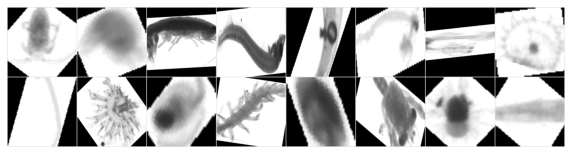

In [9]:
# Set the number of images to display
num_images = 32

loader = 'train'

sample_images(datamodule, loader, num_images)

#### Preview images from the Validation dataloader

torch.Size([3, 224, 224])

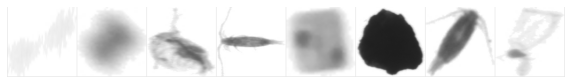

In [10]:
# Set the number of images to display
num_images = 8

loader = 'val'

sample_images(datamodule, loader, num_images)

#### Create Model

In [17]:
model = SeggregatedBACNN(
                            results = RESULTS,
                            model_name = model_name,
                            num_classes = num_classes,
                            attention_size = attention_size,
                            feature_extractor_path=feature_extractor_path,
                            freeze_feature_extractor=freeze_feature_extractor,
                            freeze_binary_head=freeze_binary_head,
                            training_only_binary_head=training_only_binary_head,
                            learning_rate = learning_rate,
                            scheduler=scheduler,
                            scheduler_parameters=scheduler_parameters,
                            loss_weights=loss_weights0,
                        )


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


INFO: Using loss_weights of [0.98, 0.01, 0.01]

feature extracator path is: swin_ZS_v3_backbone.ckpt
feature extractor path is: swin_ZS_v3_backbone.ckpt


INFO:Using 'swin_s3_base_224' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
/home/jhimbert/.local/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/s3_b-a1e95db4.pth)


"""Freezing Feature Extractor"""
"""Freezing Binary Head"""
feature extrcator path is: swin_ZS_v3_backbone.ckpt


INFO:Using 'swin_s3_base_224' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
INFO:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/s3_b-a1e95db4.pth)


feature extrcator path is: swin_ZS_v3_backbone.ckpt


INFO:Using 'swin_s3_base_224' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
INFO:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/s3_b-a1e95db4.pth)


SeggregatedBACNN(
  (criterion): WeightedCrossEntropy(
    (criterion1): CrossEntropyLoss()
    (criterion2): CrossEntropyLoss()
    (criterion3): CrossEntropyLoss()
    (criterion4): CrossEntropyLoss()
    (criterion5): CrossEntropyLoss()
  )
  (model): Modified_BA_CNN(
    (binary_head): BinaryHead(
      (feature_extractor): SwinTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (0): BasicLayer(
            (blocks): Sequential(
              (0): SwinTransformerBlock(
                (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attn): WindowAttention(
                  (qkv): Linear(in_features=96, out_features=288, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linea

#### Save all parameters for Training

In [18]:
experiment_folder_str = str(EXPERIMENT_FOLDER)

Model_Parameters = {
                        'model_name': model_name,

                        'dataset_name': dataset_name,
                        'image_folder': image_folder,
                        'learning_rate': learning_rate,
                        'learning_rate_finder': learning_rate_finder,
                        'batch_size': batch_size,
                        'seed_value': seed_value,
                        'img_size': img_size,
    
                        'attention_size': attention_size,
                        'feature_extractor_path': feature_extractor_path,
                        'freeze_feature_extractor': freeze_feature_extractor,
                        'freeze_binary_head': freeze_binary_head,
                        'training_only_binary_head': training_only_binary_head,
    
                        'num_classes': num_classes.tolist(), 
                        'sampler': sampler,
                        'experiment_folder': experiment_folder_str, 
                        'scheduler':scheduler,
                        "scheduler_parameters":scheduler_parameters,
    
                        'loss_weights0': loss_weights0,
                        'loss_weights1': loss_weights1,
                        'loss_weights2': loss_weights2,
                        'loss_weights3': loss_weights3,

                        'num_epochs0': num_epochs0,
                        'num_epochs1': num_epochs1,
                        'num_epochs2': num_epochs2,
                        'num_epochs3': num_epochs3,
    
                        'mean_std_name': saved_mean_std,
                        'manual_augmentations':manual_augmentations,
                        'number_of_augmentations': number_of_augmentations,
                        'magnitude_of_augmentations': magnitude_of_augmentations,
                }

jsonString = json.dumps(Model_Parameters, indent=4)
jsonFile = open(f'json_parameters/{base_dir_name}_v{Experiment_num}.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()